In [ ]:
import nltk
nltk.download('stopwords')

In [57]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
stop_common=set(stopwords.words('english'))
import matplotlib.pyplot as plt
import requests
import bs4
from bs4 import BeautifulSoup
import re
from tqdm import tqdm
from tqdm import tqdm_notebook
import time
from time import sleep
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer

In [85]:
cities = ['Toronto%2C+ON', 'Waterloo%2C+ON', 'Montreal%2C+QC', 'Vancouver%2C+BC', 'Calgary%2C+AB', 'Ottawa%2C+ON', 'Québec+City%2C+QC', 'Brampton%2C+ON', 'Halifax%2C+NS', 'Hamilton%2C+ON', 'Surrey%2C+BC', 'Victoria%2C+BC', 'Kitchener%2C+ON', 'Winnipeg%2C+MB', 'Edmonton%2C+AB']
len(cities)

15

In [86]:
max_results_per_city = 1000
header = {"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36" ,'referer':'https://www.google.com/'}

results = []
for i in tqdm(range(len(cities))):
    for start in range(0, max_results_per_city, 100):
        url = "https://ca.indeed.com/jobs?as_and=software+developer&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&salary=&radius=25&l="+cities[i]+"&fromage=any&limit=100&start="+str(start)+"&sort=&psf=advsrch"
        html = requests.get(url, headers = header)
        soup = BeautifulSoup(html.content, 'html.parser')
        if(len(soup.find_all('script', {'src':'https://www.google.com/recaptcha/api.js'}))==1):
            print('Captcha error(', cities[i],'): Retry in some time or use proxy.')
            break
        for row in soup.find_all('div', {'class':'jobsearch-SerpJobCard unifiedRow row result'}):
            results.append(row)
        sleep(2)

 47%|████▋     | 7/15 [03:12<03:27, 25.91s/it]

Captcha error( Québec+City%2C+QC ): Retry in some time or use proxy.


 53%|█████▎    | 8/15 [03:12<02:07, 18.20s/it]

Captcha error( Brampton%2C+ON ): Retry in some time or use proxy.


 67%|██████▋   | 10/15 [03:12<00:45,  9.02s/it]

Captcha error( Halifax%2C+NS ): Retry in some time or use proxy.
Captcha error( Hamilton%2C+ON ): Retry in some time or use proxy.


 73%|███████▎  | 11/15 [03:15<00:28,  7.04s/it]

Captcha error( Surrey%2C+BC ): Retry in some time or use proxy.


 80%|████████  | 12/15 [03:17<00:16,  5.66s/it]

Captcha error( Victoria%2C+BC ): Retry in some time or use proxy.


 93%|█████████▎| 14/15 [03:18<00:02,  2.88s/it]

Captcha error( Kitchener%2C+ON ): Retry in some time or use proxy.
Captcha error( Winnipeg%2C+MB ): Retry in some time or use proxy.


100%|██████████| 15/15 [03:18<00:00, 13.22s/it]

Captcha error( Edmonton%2C+AB ): Retry in some time or use proxy.


In [87]:
results_backup = results

In [88]:
jobs = pd.DataFrame(columns=['location', 'title', 'company', 'salary', 'summary'])

In [89]:
def get_loc(row):
    try:
        return row.find('span', {'class':'location'}).text
    except: return 'NA'


def get_comp(row):
    try:
        return row.find('span', {'class':'company'}).text.replace('\n','')
    except: return 'NA'
    
def get_job(row):
    try:
        return row.find('a', {'data-tn-element':'jobTitle'}).text.replace('\n','')
    except: return 'NA'
    
        
def get_sal(row):
    try:
        return row.find('span', {'class':'salaryText'}).text.replace('\n','')
    except: return 'NA'
    
    
def get_desc(row):
    try:
        return row.find('div', {'class':'summary'}).text.replace('\n','')
    except: return 'NA'


In [90]:
for result in results:
    location = get_loc(result)
    title = get_job(result)
    company = get_comp(result)
    salary = get_sal(result)
    desc = get_desc(result)
    jobs.loc[len(jobs)] = [location, title, company, salary, desc]

In [91]:
jobs.head(5)

,location,title,company,salary,summary
0,NA,Software Developer,Concentra Bank,"$57,756 - $136,321 a year",This position also ensures that appropriate do...
1,NA,Full Stack Developer,AGM Renovations,NA,NA
2,NA,Software Developer full stack,RIFO Realty Group Inc,"$65,000 - $85,000 a year",5+ years software development (Web) experience...
3,NA,Jr. Web Developer,Park Street Education,NA,NA
4,NA,"Software Developer, Java (Platform/Banking Teams)",GeeksForLess Canada Inc.,"$130,000 - $140,000 a year",A decent understanding of modern cloud infra/d...


In [92]:
jobs.shape

(3288, 5)

In [93]:
jobs = jobs.drop_duplicates()

In [94]:
jobs.shape

(2318, 5)

In [95]:
jobs.to_csv('scraped_results.csv', index=False, encoding='utf-8')

In [96]:
scrapped_data = pd.read_csv('scraped_results.csv')

In [97]:
salaries = scrapped_data[scrapped_data.salary.notnull()]

In [98]:
salaries.shape

(349, 5)

In [99]:
salaries

,location,title,company,salary,summary
0,NaN,Software Developer,Concentra Bank,"$57,756 - $136,321 a year",This position also ensures that appropriate do...
2,NaN,Software Developer full stack,RIFO Realty Group Inc,"$65,000 - $85,000 a year",5+ years software development (Web) experience...
4,NaN,"Software Developer, Java (Platform/Banking Teams)",GeeksForLess Canada Inc.,"$130,000 - $140,000 a year",A decent understanding of modern cloud infra/d...
5,NaN,Database Programmer,B3 Systems,"$50,000 - $80,000 a year",Appropriate experience in a software engineeri...
6,NaN,"Full Stack Java, C#, Objective-C/Swift Softwar...",YuJa - Powering Enterprise Video Everywhere,"$65,000 - $125,000 a year",You can recognize software problems and develo...
...,...,...,...,...,...
2203,"Quebec City, QC",Developer Backend / PHP & Node.js,Gilcode,$18 - $26 an hour,Gilcode aide des compagnies à transformer des ...
2215,"Quebec City, QC",Java Developer,"Objex, Inc.",$50 - $60 an hour,Hands-on experience implementing Microservices...
2245,"Quebec City, QC",Senior Software Engineer,Dalimer Corporation,"$70,000 - $75,000 a year",Integrate software components into a fully fun...
2279,NaN,Senior Full-Stack Ruby on Rails and React Soft...,NuBinary Inc,"$80,000 - $120,000 a year",We are a custom software consulting and develo...


In [100]:
salaries = salaries[salaries.location != 'Münchberg']

In [101]:
preprocess_salary = []

for i in salaries.salary:        
    if 'an hour' in i:
        i = i.replace('an hour', '').replace('$', '').replace('from', '').replace('From','')
        a = i.split('-')
        if(len(a) == 2):
            a = [float(x.strip().replace(',','')) for x in a]
            preprocess_salary.append(np.mean([float(b) for b in a])*8*300)
        else:
            a[0] = a[0].strip().replace(',','')
            preprocess_salary.append(float(a[0])*8*300)
            
    elif 'a week' in i:
        i = i.replace('a week', '').replace('$', '').replace('from', '').replace('From','')
        a = i.split('-')
        print(a)
        if(len(a) == 2):
            a = [float(x.strip().replace(',','')) for x in a]
            preprocess_salary.append(np.mean([float(b) for b in a])*52)
        else:
            a[0] = a[0].strip().replace(',','')
            preprocess_salary.append(float(a[0])*52)
    
    elif 'a month' in i:
        i = i.replace('a month', '').replace('$', '').replace('from', '').replace('From','')
        a = i.split('-')
        if(len(a) == 2):
            a = [float(x.strip().replace(',','')) for x in a]
            preprocess_salary.append(np.mean([float(b) for b in a])*12)
        else:
            a = [float(x.strip().replace(',','')) for x in a]
            preprocess_salary.append(float(a[0])*12)
    elif 'a year' in i:
        i = i.replace('a year', '').replace('$', '').replace('from', '').replace('From','')
        a = i.split('-')
        if len(a) == 2:
            a = [float(x.strip().replace(',','')) for x in a]
            preprocess_salary.append(np.mean([float(b) for b in a]))
        else:
            a[0] = a[0].strip().replace(',','')
            preprocess_salary.append(float(a[0]))


['1,250 ', ' 1,900 ']


In [102]:
for i in salaries.salary:
    if len(i.split('-')) != 1 and len(i.split('-')) != 2:
        print(i)

In [103]:
len(preprocess_salary)

349

In [104]:
salaries.salary = preprocess_salary

In [105]:
salaries.shape

(349, 5)

In [106]:
salaries.duplicated().sum()

0

In [107]:
preprocessed_data = salaries[salaries['location'].notna()]

In [108]:
preprocessed_data.to_csv('final_data.csv', index=False, encoding='utf-8')

In [109]:
salaries = pd.read_csv('final_data.csv')

In [110]:
salaries.head()

,location,title,company,salary,summary
0,"Toronto, ON",C# Developer,Brands.Buzz,65000.0,"As a C# Developer, you will have a strong unde..."
1,"Toronto, ON",Web Developer,Rose Rocket,80760.0,Develop Website architecture and determine har...
2,"Toronto, ON",Web Designer/Developer,Ontario Learning Development Foundation,34200.0,The Web Developer will be responsible for the ...
3,"Toronto, ON","Programmer, Front End Full Stack Developer",Curamoir Inc,42000.0,Material UI as a basis to style responsive exi...
4,"Toronto, ON",App Developer,Thermal Guard,42000.0,Thermal Guard Automates Temperature Screening ...


In [111]:
median_salary = np.median(salaries.salary)
median_salary

83119.0

In [112]:
salaries['high_salary'] = [1 if i > median_salary else 0 for i in salaries.salary]

In [121]:
salaries.head()
print(len(salaries))

def clean_data(data, stop_common):
    stop_common = set.union(stop_common, {'will', 'na', 'tools', 'software','full time',
                                          'skills','using', 'system', 'year', 'building', 'new',
                                         "build", "years", "scientist", "developer", "developers",
                                         "work", "knowledge", "full", "time", "provide", "looking",
                                         "role", "development", "engineer", "engineering", "including",
                                         "engineers", "working"})
    data = data.lower() #transfer to lower case
    data = data.replace("'s", "") #remove 's
    data = re.sub(r'[^\w]', ' ', data) #remove all symbol
    data = filter(lambda w: not w in stop_common,data.split(" "))#split the sentence and remove the stop words
    data = list(filter(("").__ne__, data)) #remove blank element
    
    return data

265


(-0.5, 399.5, 199.5, -0.5)

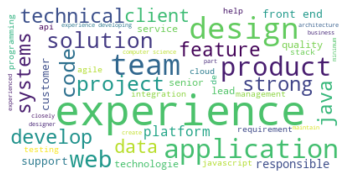

In [123]:
result = []
for i in range(jobs.shape[0]):
    result+=clean_data(jobs.iloc[i]["summary"], stop_common)
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(",".join(result))
wordcloud.to_file("./Software_Developer.png")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

#### Only Location

In [33]:
salaries.location.value_counts()

Toronto, ON          8
Montréal, QC         4
Ottawa, ON           3
Calgary, AB          2
Kitchener, ON        2
Vancouver, BC        2
Mississauga, ON      1
Richmond Hill, ON    1
Burnaby, BC          1
Richmond, BC         1
North York, ON       1
Name: location, dtype: int64

In [34]:
cities = []
states = []

for loc in salaries.location:
    items = loc.split(',')
    cities.append(items[0])
    states.append(items[1])


In [35]:
only_states = []
for state in states:
    only_states.append(re.search(r'\w+', state).group(0))
print(len(only_states))

26


In [36]:
salaries['city'] = cities
salaries['state'] = only_states

In [37]:
salaries.city = salaries.city + ", " + salaries.state

In [38]:
for i in salaries.state:
    if len(i) > 2:
        print(i)

In [39]:
salaries.head()

,location,title,company,salary,summary,high_salary,city,state
0,"Toronto, ON",Data Scientist/Analyst 120,Foilcon,192000.0,Strong business and data analysis skills.Exper...,1,"Toronto, ON",ON
1,"Toronto, ON",Data Scientist 7 to 10yrs of EXP,IT Axis Consulting.,180000.0,Strong business and data analysis skills.Exper...,1,"Toronto, ON",ON
2,"Toronto, ON",Data Scientist / Machine Learning Engineer,Leadbright Inc.,67500.0,Create and visualize data using our charting t...,0,"Toronto, ON",ON
3,"Toronto, ON",Data Scientist,Daesys,77500.0,We are currently a small but very experienced ...,0,"Toronto, ON",ON
4,"Richmond Hill, ON",Junior Data Scientist,Visual Defence Inc,50000.0,Programming and support in writing ready data ...,0,"Richmond Hill, ON",ON


In [46]:
salaries.city.nunique()

9

In [47]:
salaries.city.value_counts()

Toronto, ON          4
Montréal, QC         4
Calgary, AB          3
Mississauga, ON      2
Kitchener, ON        2
Burnaby, BC          1
Richmond Hill, ON    1
North York, ON       1
Ottawa, ON           1
Name: city, dtype: int64

In [49]:
city_dummies = pd.get_dummies(salaries.city)

X_city = city_dummies
y_city = salaries.high_salary

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_city, y_city, test_size=0.3, random_state=90)

In [51]:
rfc = RandomForestClassifier(n_estimators=300, random_state=90)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print ("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X_city, y_city, cv=10, n_jobs=-1)
print ("Cross Validation Score:\t{:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

Accuracy Score: 0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Cross Validation Score:	0.517 ± 0.32


In [52]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_city.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_medians = []
for i in X_city.columns:
    feature_medians.append(np.median(salaries[salaries.city == i].salary))

feature_importances['median_salary'] = feature_medians
feature_importances['over_or_under'] = [1 if i > median_salary else 0 for i in feature_importances.median_salary]

feature_importances.sort_values('importance', ascending=False).head(15)

,feature,importance,median_salary,over_or_under
8,"Toronto, ON",0.200426,80000.0,0
1,"Calgary, AB",0.182500,89028.0,1
4,"Montréal, QC",0.158712,87500.0,1
3,"Mississauga, ON",0.137713,86270.0,0
2,"Kitchener, ON",0.096111,82500.0,0
0,"Burnaby, BC",0.094923,95000.0,1
7,"Richmond Hill, ON",0.064979,50000.0,0
5,"North York, ON",0.064635,51500.0,0
6,"Ottawa, ON",0.000000,87384.5,1


#### Only summary

In [53]:
salaries_w_desc = salaries[salaries.summary.notnull()]

X_summ = salaries_w_desc.summary
y_summ = salaries_w_desc.high_salary

In [54]:
cv = CountVectorizer(stop_words="english")
cv.fit(X_summ)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [55]:
len(cv.get_feature_names())

188

In [56]:
X_summ_trans = pd.DataFrame(cv.transform(X_summ).todense(), columns=count_vec.get_feature_names())

NameError: name 'count_vec' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.asmatrix(X_summ_trans), y_summ, test_size=0.3,
                                                    random_state=59, stratify=y_summ)

In [ ]:
word_counts = X_summ_trans.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

In [ ]:
word_counts.to_csv('indeed-words.csv', encoding='utf-8')

In [ ]:
rfc = RandomForestClassifier(200, random_state=59)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X_summ_trans.values, y_summ.values, cv=10, n_jobs=-1)
print("Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

In [ ]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_summ_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_medians = []
feature_means = []
for i in X_summ_trans.columns:
    feature_medians.append(np.median(salaries_w_desc[salaries_w_desc.summary.str.lower().str.contains(i)].salary))
    feature_means.append(np.mean(salaries_w_desc[salaries_w_desc.summary.str.lower().str.contains(i)].salary))


feature_importances['median_salary'] = feature_medians
feature_importances['mean_salary'] = feature_means
feature_importances['over_or_under'] = [1 if i > median_salary else 0 for i in feature_importances.median_salary]

feature_importances.sort_values('importance', ascending=False).head(20)

#### Only title

In [ ]:
salaries_w_desc = salaries[salaries.summary.notnull()]

X_title = salaries_w_desc.title
y_title = salaries_w_desc.high_salary

In [ ]:
cv = CountVectorizer(stop_words="english")
cv.fit(X_title)

In [ ]:
X_title_trans = pd.DataFrame(cv.transform(X_title).todense(), columns=cv.get_feature_names())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_title_trans, y_title, test_size=0.3, random_state=59)

In [ ]:
rfc = RandomForestClassifier(200, random_state=59)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X_title_trans.values, y_title.values, cv=10, n_jobs=-1)
print("Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

In [ ]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_title_trans.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_medians = []
feature_means = []
for i in X_title_trans.columns:
    feature_medians.append(np.median(salaries_w_desc[salaries_w_desc.title.str.lower().str.contains(i)].salary))
    feature_means.append(np.mean(salaries_w_desc[salaries_w_desc.title.str.lower().str.contains(i)].salary))


feature_importances['median_salary'] = feature_medians
feature_importances['mean_salary'] = feature_means
feature_importances['over_or_under'] = [1 if i > median_salary else 0 for i in feature_importances.median_salary]

feature_importances.sort_values('importance', ascending=False).head(20)

#### Combining Title CV, Summary CV, and Location

In [ ]:
salaries_w_desc = data[data.summary.notnull()].reset_index()
city_dummies = pd.get_dummies(salaries_w_desc.city)

X = pd.concat([city_dummies, X_title_trans, X_summ_trans], axis=1)
y = salaries_w_desc.high_salary

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.3, random_state=1234, stratify=y)

In [ ]:
rfc = RandomForestClassifier(500, random_state=59)
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)
acc = accuracy_score(y_test, rfc_pred)
print("Accuracy Score:", acc.round(3))

s = cross_val_score(rfc, X.values, y.values, cv=10, n_jobs=-1)
print("Cross Validation Score: {:0.3} ± {:0.3}".format(s.mean().round(3), s.std().round(3)))

In [ ]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_medians = []
for i in city_dummies.columns:
    feature_medians.append(np.median(salaries[salaries.city == i].salary))
for i in X_title_trans.columns:
    feature_medians.append(np.median(salaries_w_desc[salaries_w_desc.title.str.lower().str.contains(i)].salary))
for i in X_summ_trans.columns:
    feature_medians.append(np.median(salaries_w_desc[salaries_w_desc.summary.str.lower().str.contains(i)].salary))

feature_importances['median_salary'] = feature_medians
feature_importances['over_or_under'] = [1 if i > median_salary else 0 for i in feature_importances.median_salary]

feature_importances.sort_values('importance', ascending=False).head(20)